In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from IPython.display import clear_output
from matplotlib.pyplot import imshow
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.metrics import *
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import backend as k
import datetime

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_df = pd.read_csv("../input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/trainlist01.txt",sep = " ",header = None,names = ['path','class'])
train_df

,path,class
0,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi,1
1,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c02.avi,1
2,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c03.avi,1
3,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c04.avi,1
4,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c05.avi,1
...,...,...
9532,YoYo/v_YoYo_g25_c01.avi,101
9533,YoYo/v_YoYo_g25_c02.avi,101
9534,YoYo/v_YoYo_g25_c03.avi,101
9535,YoYo/v_YoYo_g25_c04.avi,101


In [3]:
content = []
i = 0
n = 50
while len(content) < 10 and i < 102:
    if len(train_df[train_df['class']==i]) >= n:
        df_temp = train_df[train_df['class']==i].iloc[:n]
        path = df_temp['path']
        content.append(path)
        
    i += 1
    

content = np.array(content)

In [4]:
content = content.reshape(500,)
y = np.array([i//50 for i in range(0,500)])

In [5]:
def read_frames(root_folder,arr,each_nth=10):
    videos=[]
    for j  in range(len(arr)):
        clear_output()
        print(np.round(100*j/len(arr),3))
            
        vcap=cv2.VideoCapture(root_folder+arr[j])
        success=True
  
        frames=[]
        cnt=0
        while success:
            try:
              success,image=vcap.read()
              cnt+=1
              if cnt%each_nth==0:
                image=resize(image,(128,192))
                frames.append(image)
            except Exception as e:
                print(e)
        videos.append(frames)
    
    return videos

In [6]:
def select_frames(frames_arr , n=10):
    videos=[]
    for i in range(len(frames_arr)):
        frames=[]
        for t in np.linspace(0, len(frames_arr[i])-1, num=n):
            frames.append(frames_arr[i][int(t)])
        videos.append(frames)
        
    videos = np.array(videos)
    print(videos.shape)
    return videos

In [7]:
X_frames = read_frames("../input/ucf101/UCF101/UCF-101/",content)
X_frames = select_frames(X_frames, 10)

99.8
(500, 10, 128, 192, 3)


In [8]:
xtr, xte, ytr , yte = train_test_split(X_frames , y , shuffle=True,test_size = 0.2,random_state = 42)

In [9]:
ytr = to_categorical(ytr, 10)
yte = to_categorical(yte,10)

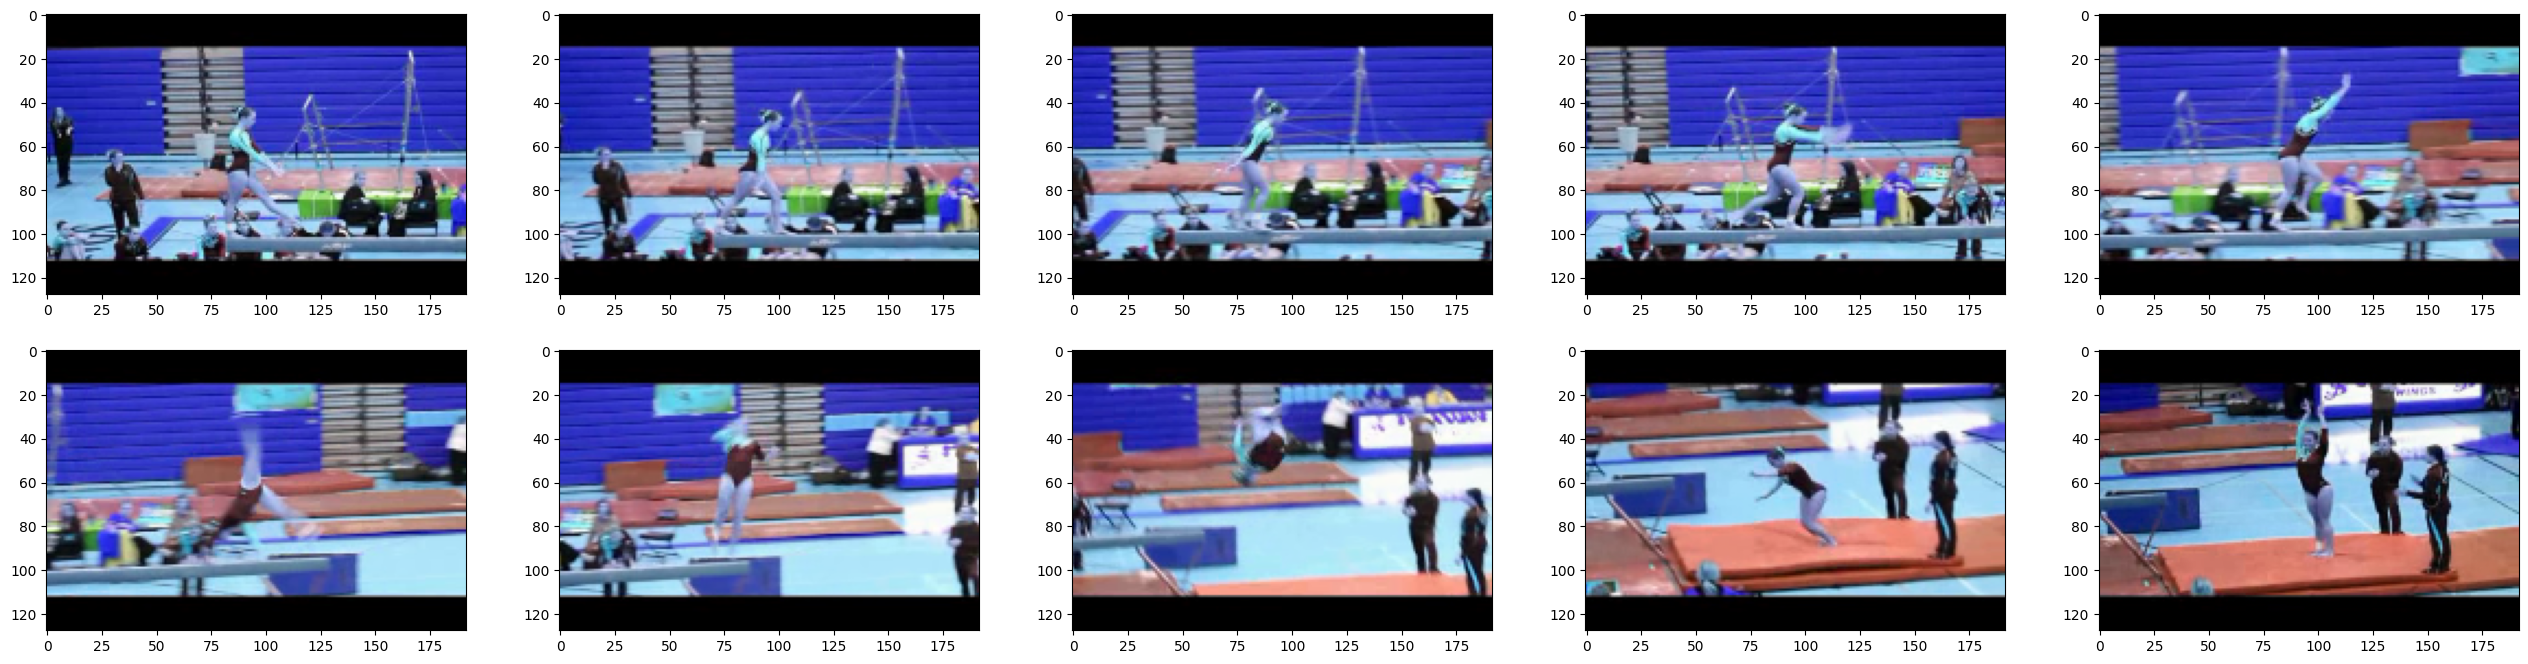

In [10]:
fig = plt.figure(figsize=(32,8))

random_video_index = np.random.randint(0,len(X_frames))

for i,image in enumerate(X_frames[random_video_index]):
    ax = plt.subplot(2,5,i+1)
    imshow(image)

In [11]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, Sequential
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(layers.Input(shape=(10, 128, 192, 3)))

model.add(BatchNormalization(momentum = 0.8))
model.add(Conv2D(16, (3, 3), activation='relu',padding = "same", kernel_regularizer=l2(0.001)))
model.add(BatchNormalization(momentum = 0.8))
model.add(MaxPooling3D(pool_size = 3))
model.add(BatchNormalization(momentum = 0.8))
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding = "same", kernel_regularizer=l2(0.001)))
model.add(BatchNormalization(momentum = 0.8))
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding = "same", kernel_regularizer=l2(0.001)))
model.add(layers.Flatten())

model.add(layers.Dense(10, activation='softmax'))

initial_learning_rate = 0.003
opt = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])



model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 10, 128, 192, 3)  12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 10, 128, 192, 16)  448       
                                                                 
 batch_normalization_1 (Batc  (None, 10, 128, 192, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 3, 42, 64, 16)    0         
 )                                                               
                                                                 
 batch_normalization_2 (Batc  (None, 3, 42, 64, 16)    64        
 hNormalization)                                        

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
model.save("model.h5")

In [13]:
history = model.fit(xtr, ytr, epochs=10, batch_size=10,validation_data=(xte, yte),shuffle  = True)

Epoch 1/10
40/40 [==============================] - 20s 102ms/step - loss: 59.2314 - accuracy: 0.3825 - val_loss: 25.6647 - val_accuracy: 0.6900
Epoch 2/10
40/40 [==============================] - 3s 71ms/step - loss: 22.6981 - accuracy: 0.7575 - val_loss: 25.1488 - val_accuracy: 0.7800
Epoch 3/10
40/40 [==============================] - 3s 71ms/step - loss: 14.1085 - accuracy: 0.8450 - val_loss: 20.2637 - val_accuracy: 0.8000
Epoch 4/10
40/40 [==============================] - 3s 72ms/step - loss: 9.8782 - accuracy: 0.8950 - val_loss: 12.5598 - val_accuracy: 0.8600
Epoch 5/10
40/40 [==============================] - 3s 71ms/step - loss: 3.6120 - accuracy: 0.9425 - val_loss: 15.1115 - val_accuracy: 0.8100
Epoch 6/10
40/40 [==============================] - 3s 79ms/step - loss: 4.9639 - accuracy: 0.9350 - val_loss: 25.4078 - val_accuracy: 0.7500
Epoch 7/10
40/40 [==============================] - 3s 71ms/step - loss: 3.9472 - accuracy: 0.9450 - val_loss: 6.7826 - val_accuracy: 0.8800
Ep

In [14]:
model.get_weights()

[array([0.9606392, 1.0177963, 1.0350442], dtype=float32),
 array([-0.02287271, -0.03983714, -0.04590208], dtype=float32),
 array([0.34621572, 0.38513258, 0.4080914 ], dtype=float32),
 array([0.07625681, 0.08195438, 0.08986962], dtype=float32),
 array([[[[ 1.07616015e-01, -1.74354106e-01,  1.69686183e-01,
            9.82327666e-03,  1.17559768e-01,  2.98144948e-03,
           -1.96729630e-01,  3.87878455e-02, -1.52555972e-01,
           -8.79284218e-02,  6.24606945e-03, -9.81707424e-02,
            9.62698460e-02,  1.20207034e-01,  9.75191128e-03,
            4.89077624e-03],
          [ 1.73517227e-01, -1.96481019e-01, -5.62008843e-02,
           -1.12293355e-01,  1.30316958e-01, -2.09229991e-01,
            9.37356055e-02, -1.07592642e-01, -7.10377097e-03,
           -1.74109295e-01, -1.39386714e-01,  1.04536988e-01,
            1.24873355e-01, -2.19955035e-02,  7.13996869e-03,
            1.56731978e-01],
          [ 1.71601661e-02, -7.79248178e-02, -1.93805665e-01,
           -1.78

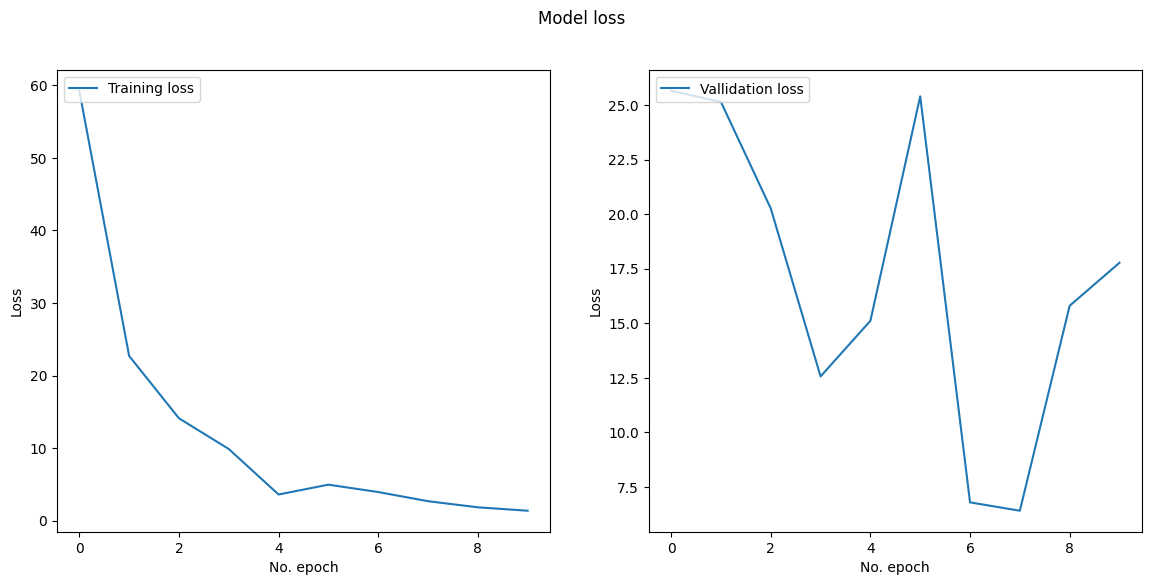

In [15]:
fig = plt.figure(figsize=(14,6))

ax = plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training loss')
ax.legend(loc="upper left")
plt.ylabel('Loss')
plt.xlabel('No. epoch')
ax = plt.subplot(1,2,2)
plt.plot(history.history['val_loss'], label='Vallidation loss')
ax.legend(loc="upper left")
fig.suptitle('Model loss')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.show()

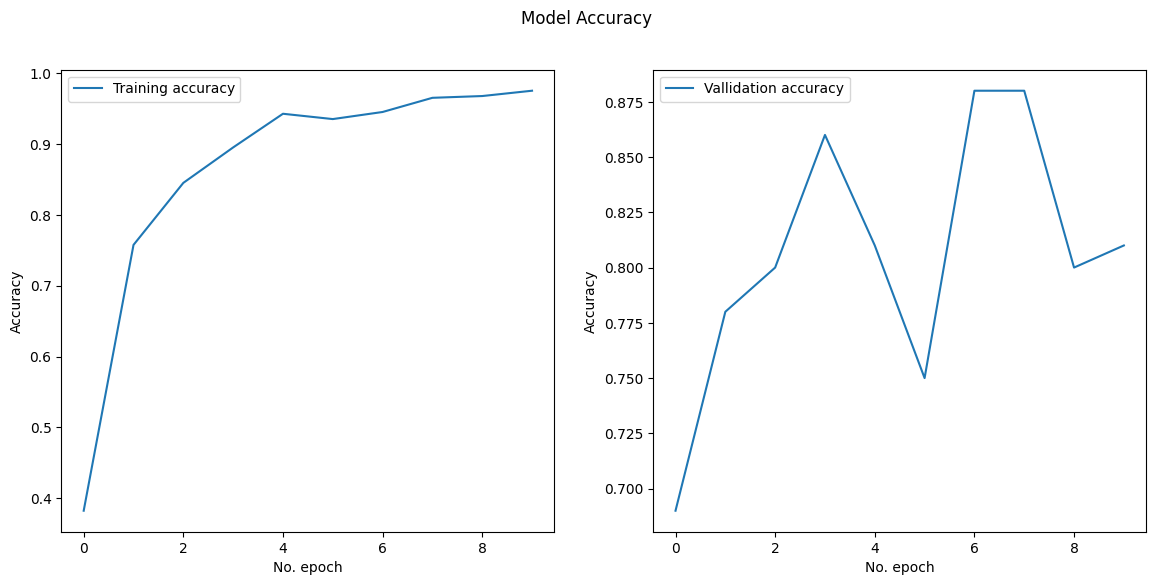

In [16]:
fig = plt.figure(figsize=(14,6))

ax = plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training accuracy')
ax.legend(loc="upper left")
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
ax = plt.subplot(1,2,2)
plt.plot(history.history['val_accuracy'], label='Vallidation accuracy')
ax.legend(loc="upper left")
fig.suptitle('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.show()

In [17]:
classes = []
for i in range(len(content)):
    class_name = content[i].split('/')[0]
    if class_name not in classes:
        classes.append(class_name)
        
num_classes = [i for i in range(10)]

class_map = dict(zip(num_classes,classes))

In [18]:
random_videos = np.random.randint(0,len(xte),size=(10))
predicted  = model.predict(xte[random_videos],batch_size = 10)
predicted  = np.argmax(predicted,axis=1)

1/1 [==============================] - 0s 208ms/step


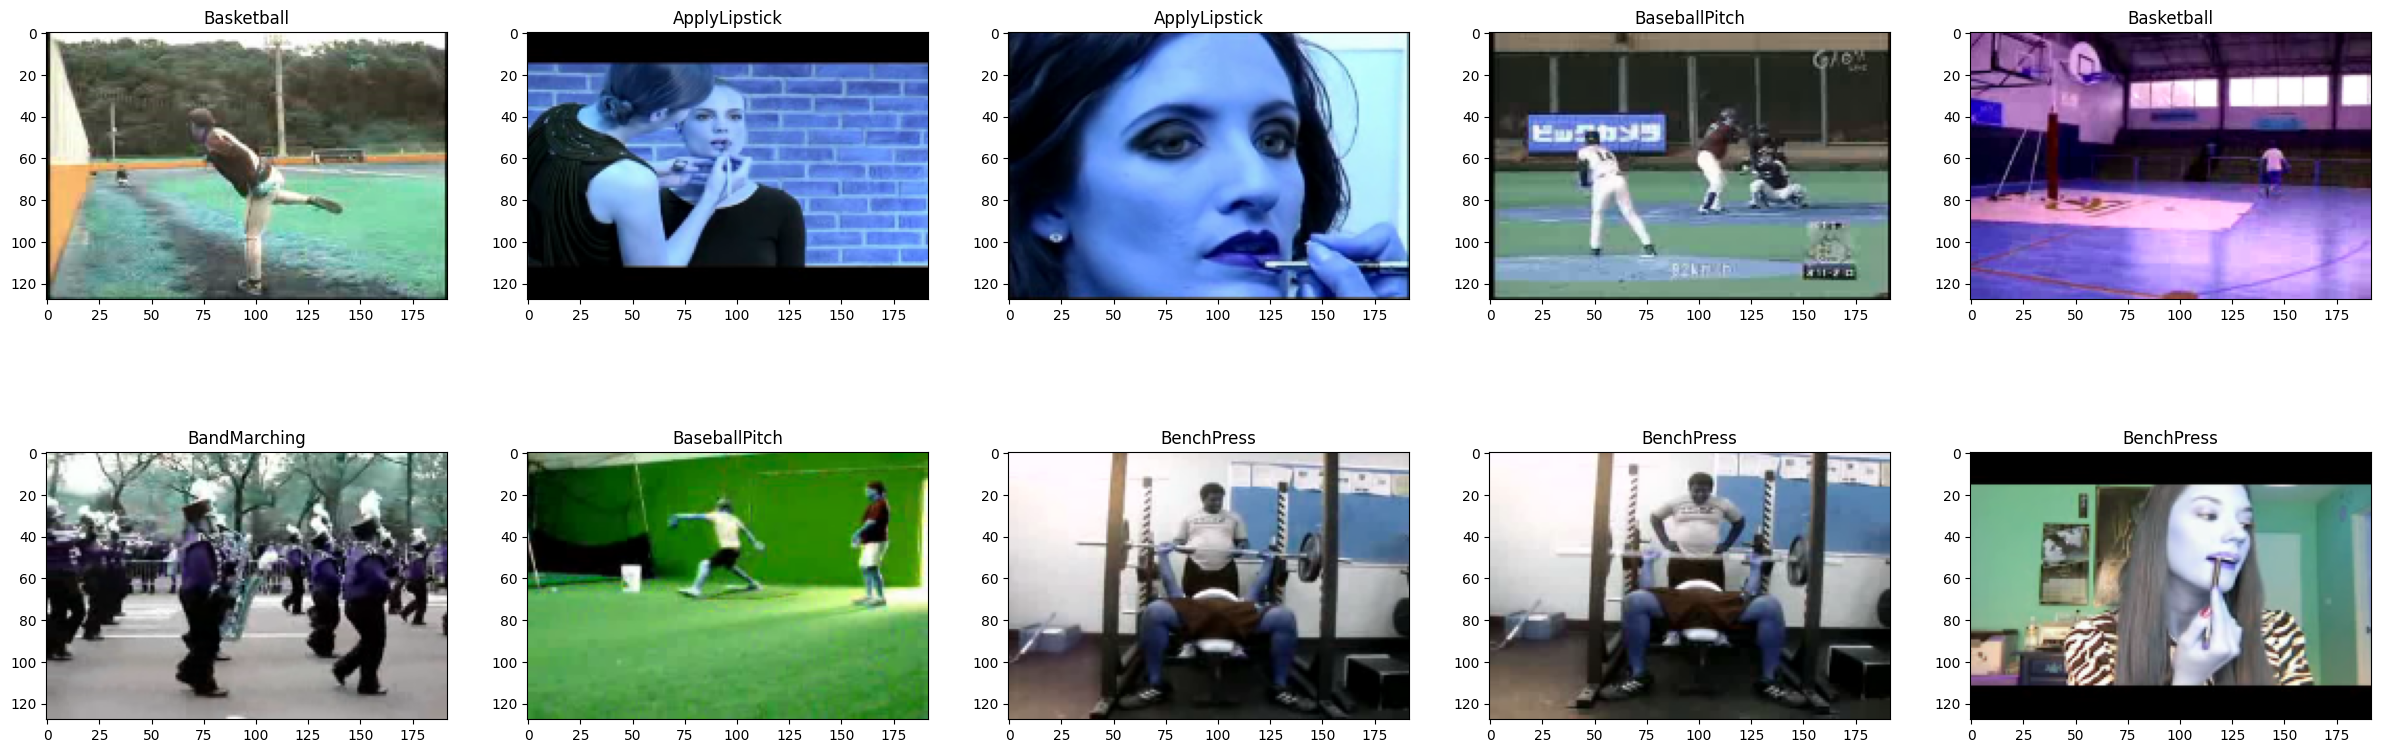

In [19]:
fig = plt.figure(figsize=(30,10))

for i,rand_indx in enumerate(random_videos):
    ax = plt.subplot(2,5,i+1)
    video = xte[rand_indx]
    frame = video[np.random.randint(0,10)]
    ax.set_title(class_map[predicted[i]])
    imshow(frame)

In [20]:
from sklearn.metrics import accuracy_score



In [21]:
model.save("new.h5")